In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from scipy.integrate import quad
from numpy.linalg import eig
import pandas as pd

In [2]:
data = {
    'Planet Name': ['TRAPPIST-1 b','TRAPPIST-1 c','TRAPPIST-1 d',
                    'TRAPPIST-1 e','TRAPPIST-1 f','TRAPPIST-1 g'
                    ,'TRAPPIST-1 h'] , 
     'Period(day)':  [1.510826,2.421937,4.049219,6.101013,9.207540,
                     12.352446,18.772866],
     'a (10^11 cm)' : [1.726,2.364,3.331,4.376,5.758,7.006, 9.529],
     'Radius (10^8 cm)' : [7.119,6.995,5.026,5.868,6.664,7.204,4.817] ,
     'Mass (10^27 g)' : [8.211,7.814,2.316,4.132,6.205,7.890,1.945],
    'Core density (g cm^-3)' : [12.0,12.0,10.0,12.0,12.0,12.0,10.0]
    }
Table1 = pd.DataFrame(data=data)
mass = Table1['Mass (10^27 g)'].to_numpy()
R = Table1['Radius (10^8 cm)'].to_numpy()

den = mass/((4/3)*pi*R**3)*1000
Table1['Mean density (g cm^-3)'] = den

In [3]:
Table1

,Planet Name,Period(day),a (10^11 cm),Radius (10^8 cm),Mass (10^27 g),Core density (g cm^-3),Mean density (g cm^-3)
0,TRAPPIST-1 b,1.510826,1.726,7.119,8.211,12.0,5.433135
1,TRAPPIST-1 c,2.421937,2.364,6.995,7.814,12.0,5.450315
2,TRAPPIST-1 d,4.049219,3.331,5.026,2.316,10.0,4.354943
3,TRAPPIST-1 e,6.101013,4.376,5.868,4.132,12.0,4.882041
4,TRAPPIST-1 f,9.207540,5.758,6.664,6.205,12.0,5.005509
5,TRAPPIST-1 g,12.352446,7.006,7.204,7.890,12.0,5.038106
6,TRAPPIST-1 h,18.772866,9.529,4.817,1.945,10.0,4.154331


In [4]:
#Integratin functionality
def b_1(x):
    return (1/pi)*(np.cos(x)/(1 - 2*alpha*np.cos(x) + alpha**2
                             )**(3/2))
# ans_b1,err_b2=quad(b_1,0,2*pi)
def b_2(x):
    return (1/pi)*(np.cos(2*x)/(1 - 2*alpha*np.cos(x) + alpha**2
                             )**(3/2))

In [5]:
#--- Required information of Jupiter (1) and Saturn (2) --------
number_of_planets = 7
G = 6.67 * 10**-8 # cm^3 g^-1 s^-2
J2 = 0.0
J4 = 0.0
rad_sec = (180/pi) *(1/(3.17098*10**-8)) #deg/year

#Array of Inclination(I), increasing order of semi-major axis(a),
#mean motion in degree/year(n) and mass/mass_of_star(m_mc).
I = np.array([-0.055,-0.005,0.113,0.010,-0.043,-0.041,0.022]) #deg
omega = np.zeros((7)) #Assuming omega angle for inclination is zero
e_cosw = np.array([-2.15,0.55,-4.96,4.33,-8.40,3.80,-3.65]) * 10**-3 #Includes the cos term with the angle
e_sinw = np.array([2.17,0.01,2.67,-4.61,-0.51,1.28,-0.02]) * 10**-3#Includes the cos term with the angle
m_sun = 1988500.0 #10^27 g (NASA)
m_star = 0.089 * m_sun
r_sun = 0.69570 #10^11 cm (NASA)
r_star = 0.117 * r_sun

a = Table1['a (10^11 cm)']
a = a.to_numpy()

M = Table1['Mass (10^27 g)'] 
M = M.to_numpy()

m_mc = M/m_star #unitless
m_mc = m_mc.astype(float)
gm = G*m_star #cm^3 s^-2

inside_sqrt = (gm*(1+m_mc))/a**3
n_rad_per_sec = np.sqrt(inside_sqrt/10**6) #rad/sec
#print(n_rad_per_sec)
n = np.sqrt(inside_sqrt/10**6)*rad_sec #deg/year

In [6]:
#Matrices (A & B)

A = np.zeros((number_of_planets,number_of_planets))
B = np.zeros((number_of_planets,number_of_planets))

for j in range(0,number_of_planets):
    dummy_sum = 0
    for k in range(0,number_of_planets):
        if k!=j:
            if k<j:
                alpha = a[k]/a[j] 
                alpha_bar = 1
            if k>j:
                alpha = a[j]/a[k]
                alpha_bar = alpha
            ans_b1,err_b1 = quad(b_1,0,2*pi)
            ans_b2,err_b2 = quad(b_2,0,2*pi)
            
            A[j,k] = -n[j] * (1/4) * (m_mc[k]/(1 + m_mc[j])) * alpha * alpha_bar * ans_b2
            B[j,k] = n[j] * (1/4) * (m_mc[k]/(1 + m_mc[j])) * alpha * alpha_bar * ans_b1
            
            dummy_sum += (m_mc[k]/(1 + m_mc[j]))* alpha * alpha_bar * ans_b1
       
    A[j,j] = n[j] *((3/2)*J2*(r_star/a[j])**2 - (27/8)*(J2**2)*
                    (r_star/a[j])**4 - (15/4)*J4*(r_star/a[j])**4 + (1/4)*dummy_sum)
    B[j,j] = -n[j] *((3/2)*J2*(r_star/a[j])**2 - (27/8)*(J2**2)*
                    (r_star/a[j])**4 - (15/4)*J4*(r_star/a[j])**4 + (1/4)*dummy_sum)


#Calculating eigenvalues(deg/year) and eigvectors(radians)
eigvals_B, eigvecs_B = eig(B)
idx = eigvals_B.argsort()[::1]   
eigvals_B = eigvals_B[idx]
eigvecs_B = eigvecs_B[:,idx]
eigvals_B = eigvals_B.real

eigvals_A, eigvecs_A = eig(A)
idx = eigvals_A.argsort()[::-1]   
eigvals_A = eigvals_A[idx]
eigvecs_A = eigvecs_A[:,idx]
eigvals_A = eigvals_A.real

At t=0:

$h_{j} = \sum_{i=1}^{n} S_{i}sin(\beta_{i}) \times \bar{e_{ji}}$

$k_{j} = \sum_{i=1}^{n} S_{i}cos(\beta_{i}) \times \bar{e_{ji}}$

$p_{j} = \sum_{i=1}^{n} T_{i}sin(\gamma_{i}) \times \bar{I_{ji}}$

$q_{j} = \sum_{i=1}^{n} T_{i}cos(\gamma_{i}) \times \bar{I_{ji}}$

In [7]:
# Inclination was converted into radians

#Equation 7.18 and 7.19 from Solar System Dynamics
h = e_sinw
k = e_cosw
p = (I*(pi/180)) * np.sin(omega * (pi/180))
q = (I*(pi/180)) * np.cos(omega * (pi/180))

#Solving for Sbeta,Tgamma
S_sinB = np.linalg.solve(eigvecs_A,h)
S_cosB = np.linalg.solve(eigvecs_A,k)
T_sinG = np.linalg.solve(eigvecs_B,p)
T_cosG = np.linalg.solve(eigvecs_B,q)

#Solving for S,beta,T,gamma
beta = np.arctan(S_sinB/S_cosB) #rad
gamma = np.zeros((7)) #rad

S = S_sinB/np.sin(beta)
T = T_cosG

In [8]:
# # Scaled eigenvectors
# scaled_eigvecsA = eigvecs_A * S
# scaled_eigvecsB = eigvecs_B * T #rad

# Not ignoring the last mode of inclination

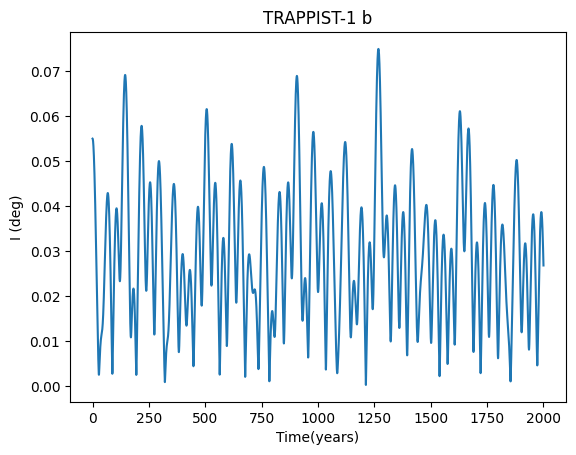

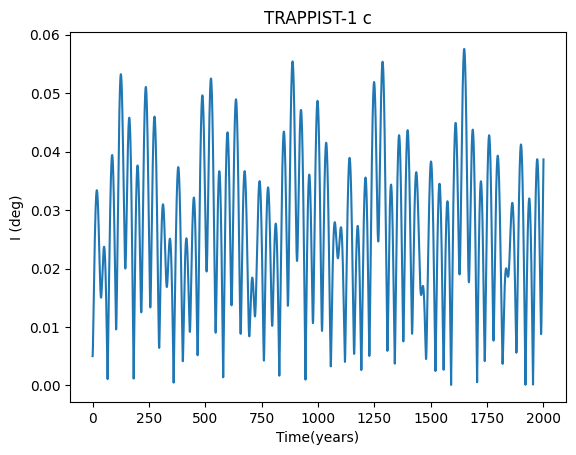

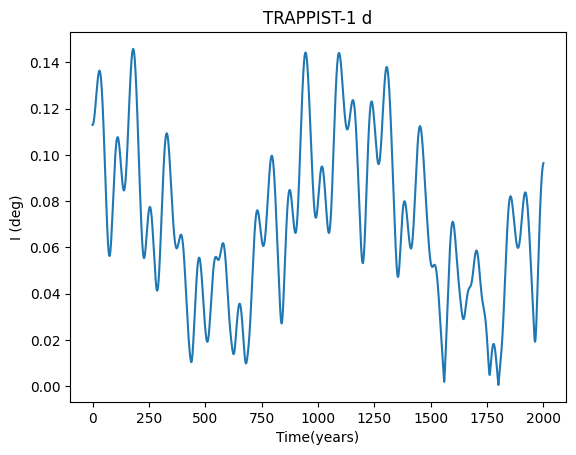

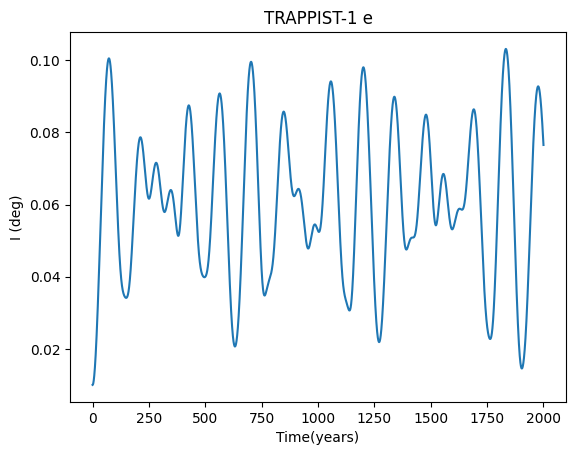

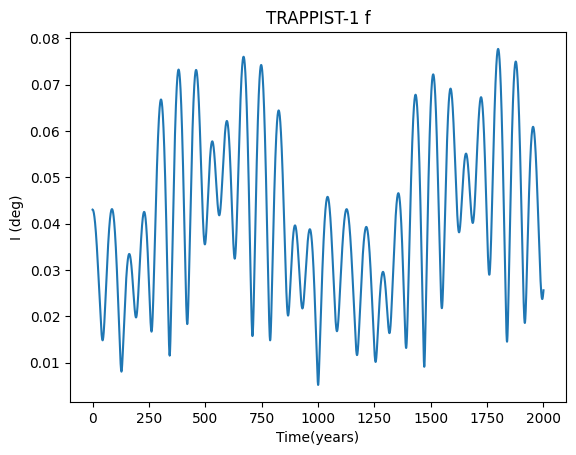

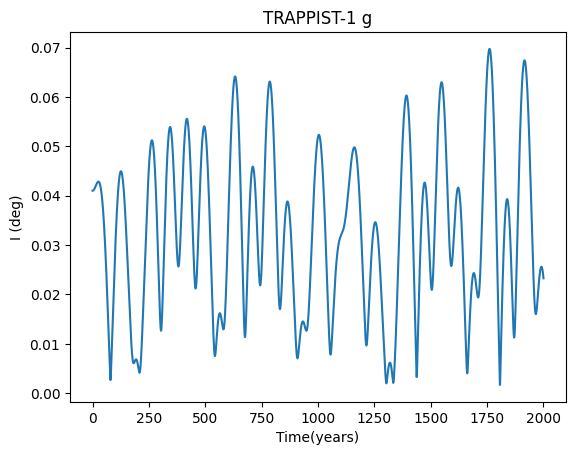

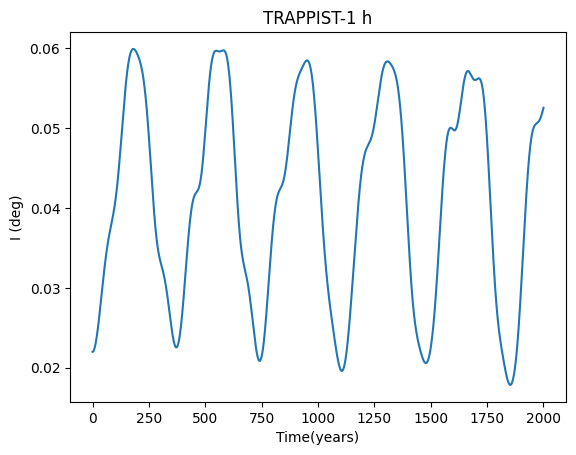

In [9]:
iterations = 10**5
timeline = np.linspace(0,2000,iterations)

p_time = np.zeros([number_of_planets,iterations])
q_time = np.zeros([number_of_planets,iterations])

for i in range(iterations):
    p_time[:,i] = np.matmul(eigvecs_B,T*np.sin(eigvals_B*timeline[i]*(pi/180) ))
    q_time[:,i] = np.matmul(eigvecs_B,T*np.cos(eigvals_B*timeline[i]*(pi/180) ))

I_time = np.sqrt(p_time**2 + q_time**2) #rad

for i in range(len(I_time)):
    plt.plot(timeline,I_time[i]*(180/pi)) #deg
    plt.xlabel('Time(years)')
    plt.ylabel('I (deg)')
    plt.title(Table1['Planet Name'][i])
    #plt.savefig(f"../New results/Initial_condition_inclination/{Table1['Planet Name'][i]}.png")
    plt.show()

In [10]:
initial = np.sqrt(e_cosw**2 + e_sinw**2)

In [11]:
iterations = 10**5
timeline = np.linspace(0,2000,iterations)

h_time = np.zeros([number_of_planets,iterations])
k_time = np.zeros([number_of_planets,iterations])

for i in range(iterations):
    h_time[:,i] = np.matmul(eigvecs_A,S*np.sin(eigvals_A*timeline[i]*(pi/180) + beta))
    k_time[:,i] = np.matmul(eigvecs_A,S*np.cos(eigvals_A*timeline[i]*(pi/180) + beta))

e_time = np.sqrt(h_time**2 + k_time**2)

for i in range(len(e_time)):
    print(initial[i],e_time[i,0])
#     plt.plot(timeline,e_time[i])
#     plt.xlabel('Time(years)')
#     plt.ylabel('e') 
#     plt.title(Table1['Planet Name'][i])
#     #plt.savefig(f"../New results/Initial_condition_ecc/{Table1['Planet Name'][i]}.png")
#     plt.show()

0.0030547340309755285 0.0030547340309755285
0.0005500909015790027 0.0005500909015790026
0.005632983223834418 0.005632983223834419
0.006324634376784164 0.006324634376784162
0.008415467901430081 0.008415467901430081
0.004009788024322483 0.0040097880243224835
0.003650054794109261 0.0036500547941092612


In [12]:
iterations = 10**5
timeline = np.linspace(0,10000,iterations)

h_time = np.zeros([number_of_planets,iterations])
k_time = np.zeros([number_of_planets,iterations])

for i in range(iterations):
    h_time[:,i] = np.matmul(eigvecs_A,S*np.sin(eigvals_A*timeline[i]*(pi/180) + beta))
    k_time[:,i] = np.matmul(eigvecs_A,S*np.cos(eigvals_A*timeline[i]*(pi/180) + beta))

e_time10 = np.sqrt(h_time**2 + k_time**2)


# Eigen Tables

In [13]:
data = {
    'Name': ['TRAPPIST-1 b','TRAPPIST-1 c','TRAPPIST-1 d',
                    'TRAPPIST-1 e','TRAPPIST-1 f','TRAPPIST-1 g'
                    ,'TRAPPIST-1 h'] ,
    'Mode 1' : eigvecs_B[:,0],
    'Mode 2' : eigvecs_B[:,1],
    'Mode 3' : eigvecs_B[:,2],
    'Mode 4' : eigvecs_B[:,3],
    'Mode 5' : eigvecs_B[:,4],
    'Mode 6' : eigvecs_B[:,5],
    }
Table2 = pd.DataFrame(data=data)
data = {
    'Name' : ['Frequency(deg/yr)'],
    'Mode 1' : eigvals_B[0],
    'Mode 2' : eigvals_B[1],
    'Mode 3' : eigvals_B[2],
    'Mode 4' : eigvals_B[3],
    'Mode 5' : eigvals_B[4],
    'Mode 6' : eigvals_B[5],
}
Table3 = pd.DataFrame(data=data)

period = abs(360/eigvals_B)
data = {
    'Name' : ['Period(years)'],
    'Mode 1' : period[0],
    'Mode 2' : period[1],
    'Mode 3' : period[2],
    'Mode 4' : period[3],
    'Mode 5' : period[4],
    'Mode 6' : period[5],
}
Table4 = pd.DataFrame(data=data)
Table_dummy = pd.concat([Table2,Table3],ignore_index=True)
Table_eig_B = pd.concat([Table_dummy,Table4],ignore_index=True)

In [14]:
Table_eig_B.style.hide(axis='index')

Name,Mode 1,Mode 2,Mode 3,Mode 4,Mode 5,Mode 6
TRAPPIST-1 b,0.692316,0.124797,0.137134,0.207505,-0.250851,0.404387
TRAPPIST-1 c,-0.696612,0.033327,0.045064,0.141908,-0.229812,0.384207
TRAPPIST-1 d,0.188106,-0.835304,-0.831335,-0.402047,-0.087210,0.253375
TRAPPIST-1 e,0.006228,0.390618,0.007357,-0.834637,0.129479,0.045882
TRAPPIST-1 f,0.002488,-0.327513,0.464408,-0.029426,0.266064,-0.129964
TRAPPIST-1 g,0.000650,0.160117,-0.268218,0.273858,0.278644,-0.190602
TRAPPIST-1 h,0.000237,-0.009940,0.019377,-0.051766,-0.843479,-0.754541
Frequency(deg/yr),-9.935497,-5.105163,-4.788402,-2.843419,-0.974150,-0.611234
Period(years),36.233720,70.516844,75.181657,126.608145,369.552973,588.972146


In [15]:
data = {
    'Name': ['TRAPPIST-1 b','TRAPPIST-1 c','TRAPPIST-1 d',
                    'TRAPPIST-1 e','TRAPPIST-1 f','TRAPPIST-1 g'
                    ,'TRAPPIST-1 h'] ,
    'Mode 1' : eigvecs_A[:,0],
    'Mode 2' : eigvecs_A[:,1],
    'Mode 3' : eigvecs_A[:,2],
    'Mode 4' : eigvecs_A[:,3],
    'Mode 5' : eigvecs_A[:,4],
    'Mode 6' : eigvecs_A[:,5],
    'Mode 7' : eigvecs_A[:,6],
    }
Table2 = pd.DataFrame(data=data)
data = {
    'Name' : ['Frequency(deg/yr)'],
    'Mode 1' : eigvals_A[0],
    'Mode 2' : eigvals_A[1],
    'Mode 3' : eigvals_A[2],
    'Mode 4' : eigvals_A[3],
    'Mode 5' : eigvals_A[4],
    'Mode 6' : eigvals_A[5],
    'Mode 7' : eigvals_A[6],
}
Table3 = pd.DataFrame(data=data)

period = abs(360/eigvals_A)
data = {
    'Name' : ['Period(years)'],
    'Mode 1' : period[0],
    'Mode 2' : period[1],
    'Mode 3' : period[2],
    'Mode 4' : period[3],
    'Mode 5' : period[4],
    'Mode 6' : period[5],
    'Mode 7' : period[6],
}
Table5 = pd.DataFrame(data=data)
Table_dummy = pd.concat([Table2,Table3],ignore_index=True)
Table_eig_A = pd.concat([Table_dummy,Table5],ignore_index=True)

In [16]:
Table_eig_A.style.hide(axis='index')

Name,Mode 1,Mode 2,Mode 3,Mode 4,Mode 5,Mode 6,Mode 7
TRAPPIST-1 b,-0.689864,0.134091,-0.133964,-0.222054,-0.613672,-0.138667,-0.106984
TRAPPIST-1 c,0.697270,0.033738,-0.043454,-0.158800,-0.584473,-0.140413,-0.114267
TRAPPIST-1 d,-0.194655,-0.872517,0.781682,0.367160,-0.403196,-0.162278,-0.172061
TRAPPIST-1 e,-0.002795,0.357836,0.046250,0.848669,-0.112107,-0.203249,-0.282764
TRAPPIST-1 f,-0.001671,-0.273314,-0.528330,0.045733,0.153300,-0.210214,-0.387407
TRAPPIST-1 g,-0.000291,0.129571,0.295731,-0.257616,0.221591,-0.194377,-0.432094
TRAPPIST-1 h,-0.000094,-0.007734,-0.020235,0.044399,-0.184552,0.900799,-0.727425
Frequency(deg/yr),9.204595,4.956040,4.647782,2.812361,1.335866,0.881508,0.419714
Period(years),39.110901,72.638646,77.456299,128.006346,269.488027,408.391070,857.727776
